In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
from scipy.sparse import csr_matrix,load_npz
import csv

sc.settings.verbosity = 3             
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=100, figsize=(6,6))
sc.settings.figdir = 'figures/hematopoiesis'

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 7.2.0
asciitree           NA
attr                21.4.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cairo               1.19.1
cffi                1.14.1
cloudpickle         2.0.0
colorama            0.4.4
cupy                8.0.0
cupy_backends       NA
cupyx               NA
cycler              0.10.0
cython_runtime      NA
dask                2022.02.0
dateutil            2.8.1
decorator           4.4.2
fasteners           0.17.3
fastrlock           0.5
fsspec              2022.5.0
google              NA
h5py                3.7.0
icu                 2.4.2
igraph              0.9.9
ipykernel           5.3.4
ipython_genutils    0.2.0
jedi                0.17.2
jinja2              2.11.3
joblib              0.17.0
kiwisolver          1.2.0
leidenalg           0.8.9
llvmlite            0.35.0
louvain             0.6.1
markupsafe          1.1.1
matplotlib          3.4.3
more_itertools      8.4

# 1. Preprocessing

## 1.1 Read in Data

In [2]:
df_metadata = pd.read_csv('../data/hematopoiesis/result_0_mapping_RNA/metadata.tsv',sep='\t',index_col=0)
df_genes = pd.read_csv('../data/hematopoiesis/result_0_mapping_RNA/genes.tsv',index_col=0)
mat = load_npz('../data/hematopoiesis/result_0_mapping_RNA/mat.npz')

RNA_all = sc.AnnData(X=csr_matrix(mat).T,obs=df_metadata,var=df_genes)
RNA_all.var_names_make_unique()
RNA_all

/home/jo/anaconda3/envs/wip/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """
/home/jo/anaconda3/envs/wip/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 86665 × 33538
    obs: 'barcode', 'sample_id', 'label'

In [3]:
### Subset by RNA days samples
Included = ['Day0','Day1','Day3','Day4','Day5','Day6','Day7','Day8','Day9','Day11_Fresh','Day12']
RNA_days = RNA_all[RNA_all.obs.label.isin(Included),:]

RNA_days

View of AnnData object with n_obs × n_vars = 51439 × 33538
    obs: 'barcode', 'sample_id', 'label'

In [4]:
### Subset by RNA Refs samples
Included = ['CD33pos','CD34negCD33dim','CD34posCD33dim','CD34posCD33neg']
RNA_ref = RNA_all[RNA_all.obs.label.isin(Included),:]

#del RNA_all
RNA_ref

View of AnnData object with n_obs × n_vars = 24772 × 33538
    obs: 'barcode', 'sample_id', 'label'

## 1.2 QC

### RNA days only

/home/jo/anaconda3/envs/wip/lib/python3.7/site-packages/ipykernel_launcher.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  


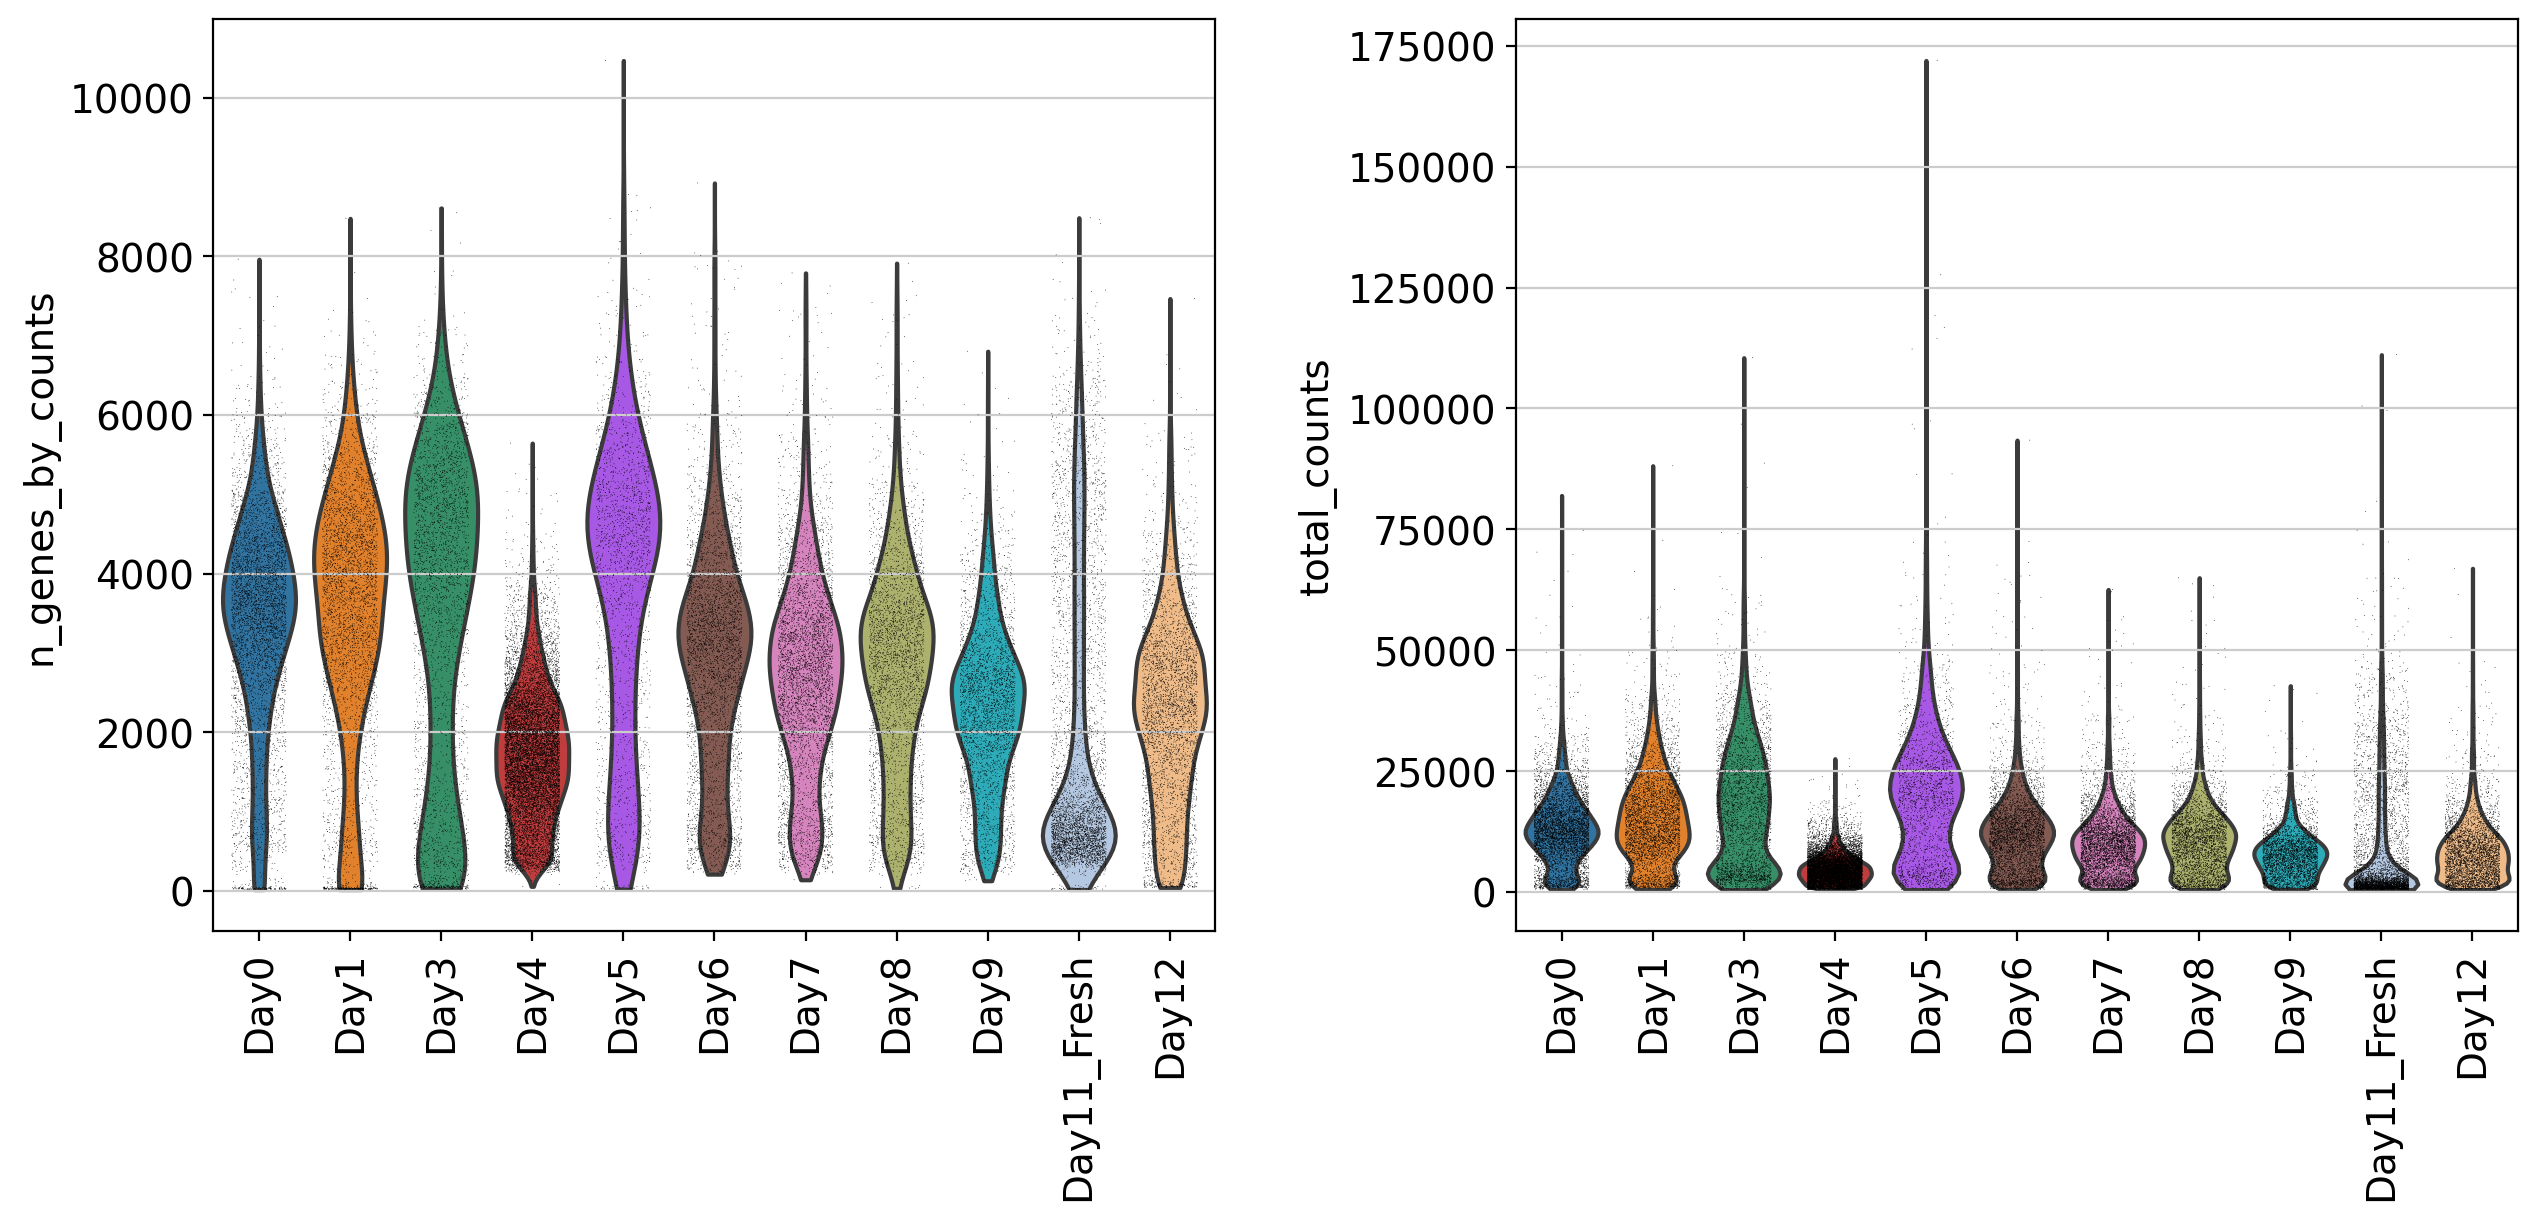

In [4]:
### before filtering
RNA_days.var['mt'] = RNA_days.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(RNA_days, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(RNA_days, ['n_genes_by_counts', 'total_counts'],
             jitter=0.3, multi_panel=True,size=0.3,rotation=90,
             groupby='label', save = False)

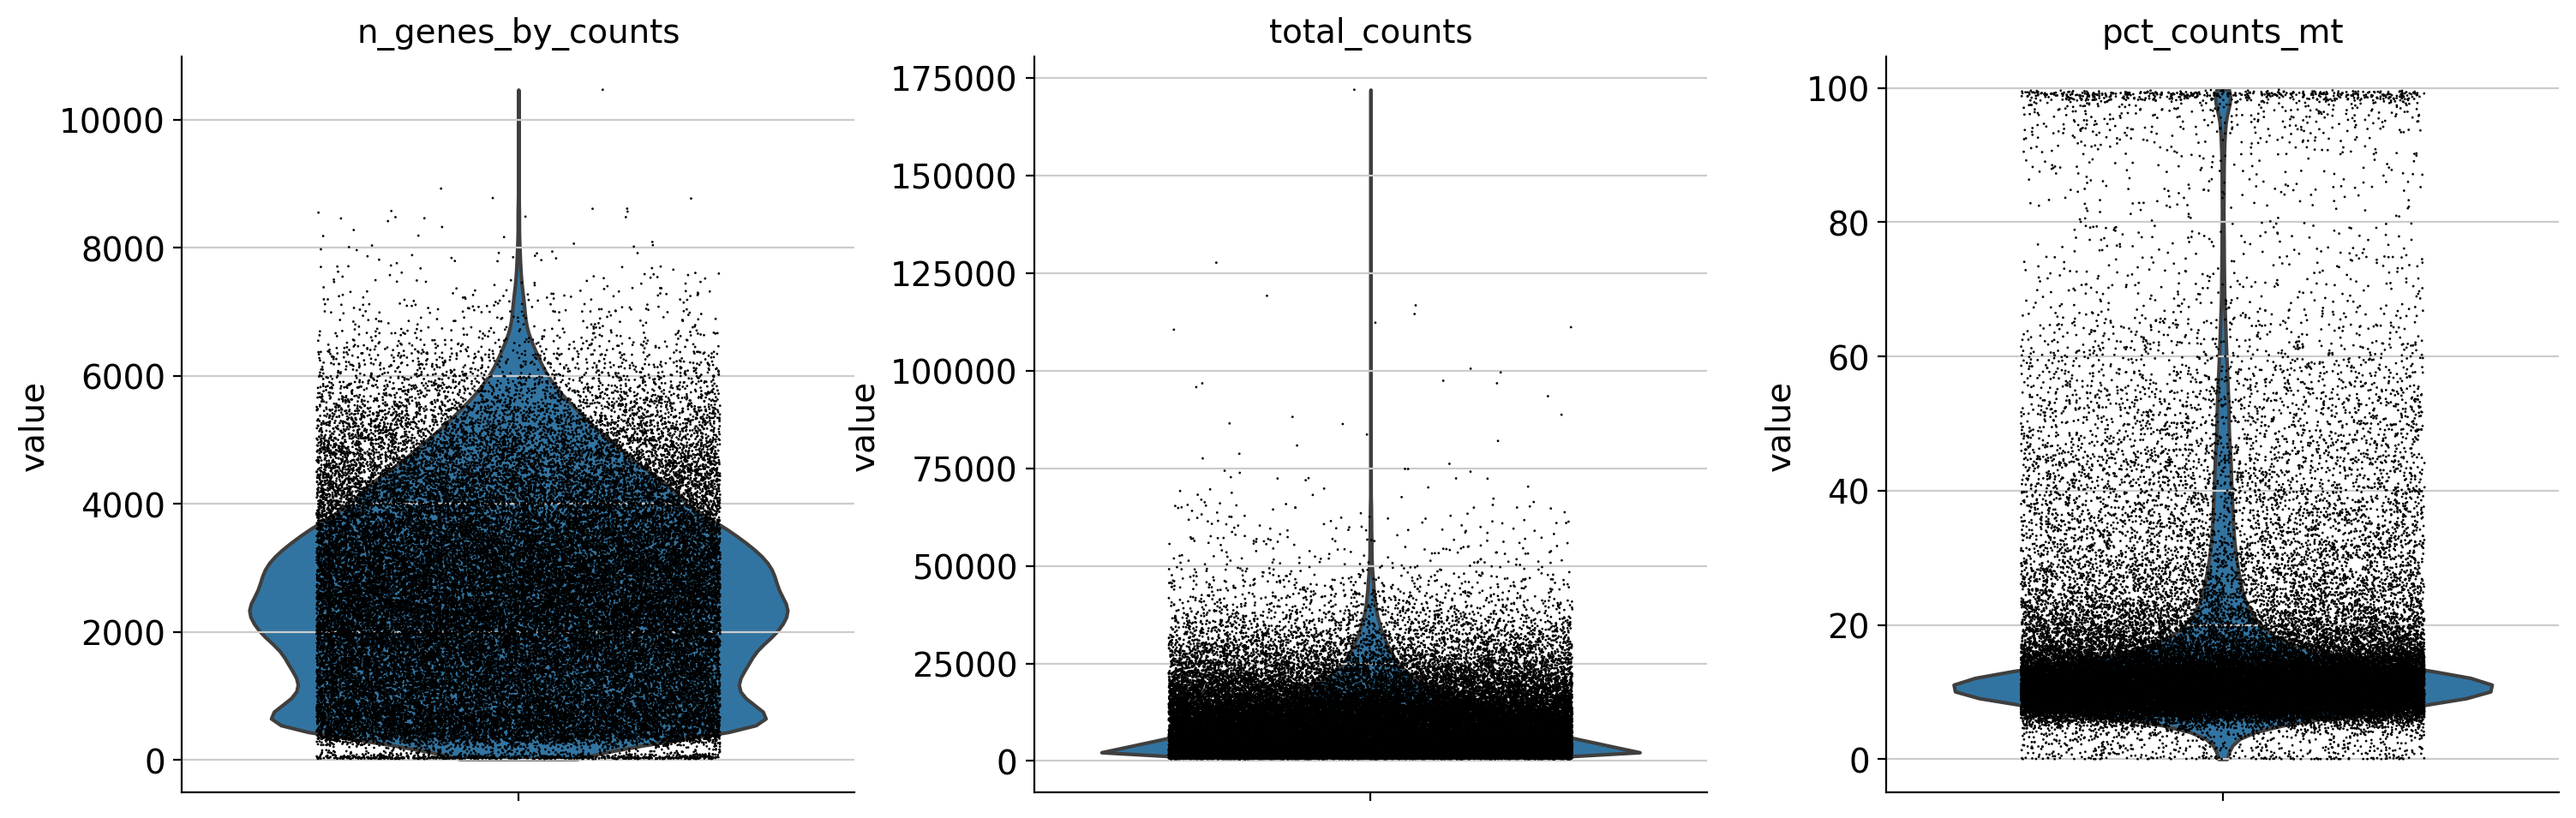

In [5]:
sc.pl.violin(RNA_days, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.3, multi_panel=True, save = False)

In [6]:
sc.pp.filter_cells(RNA_days, min_genes=200)
sc.pp.filter_genes(RNA_days, min_cells=3)

RNA_days = RNA_days[RNA_days.obs.n_genes_by_counts < 9000, :]
RNA_days = RNA_days[RNA_days.obs.pct_counts_mt < 25, :]

RNA_days

filtered out 862 cells that have less than 200 genes expressed
filtered out 10836 genes that are detected in less than 3 cells


View of AnnData object with n_obs × n_vars = 44370 × 22702
    obs: 'barcode', 'sample_id', 'label', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'label_colors'

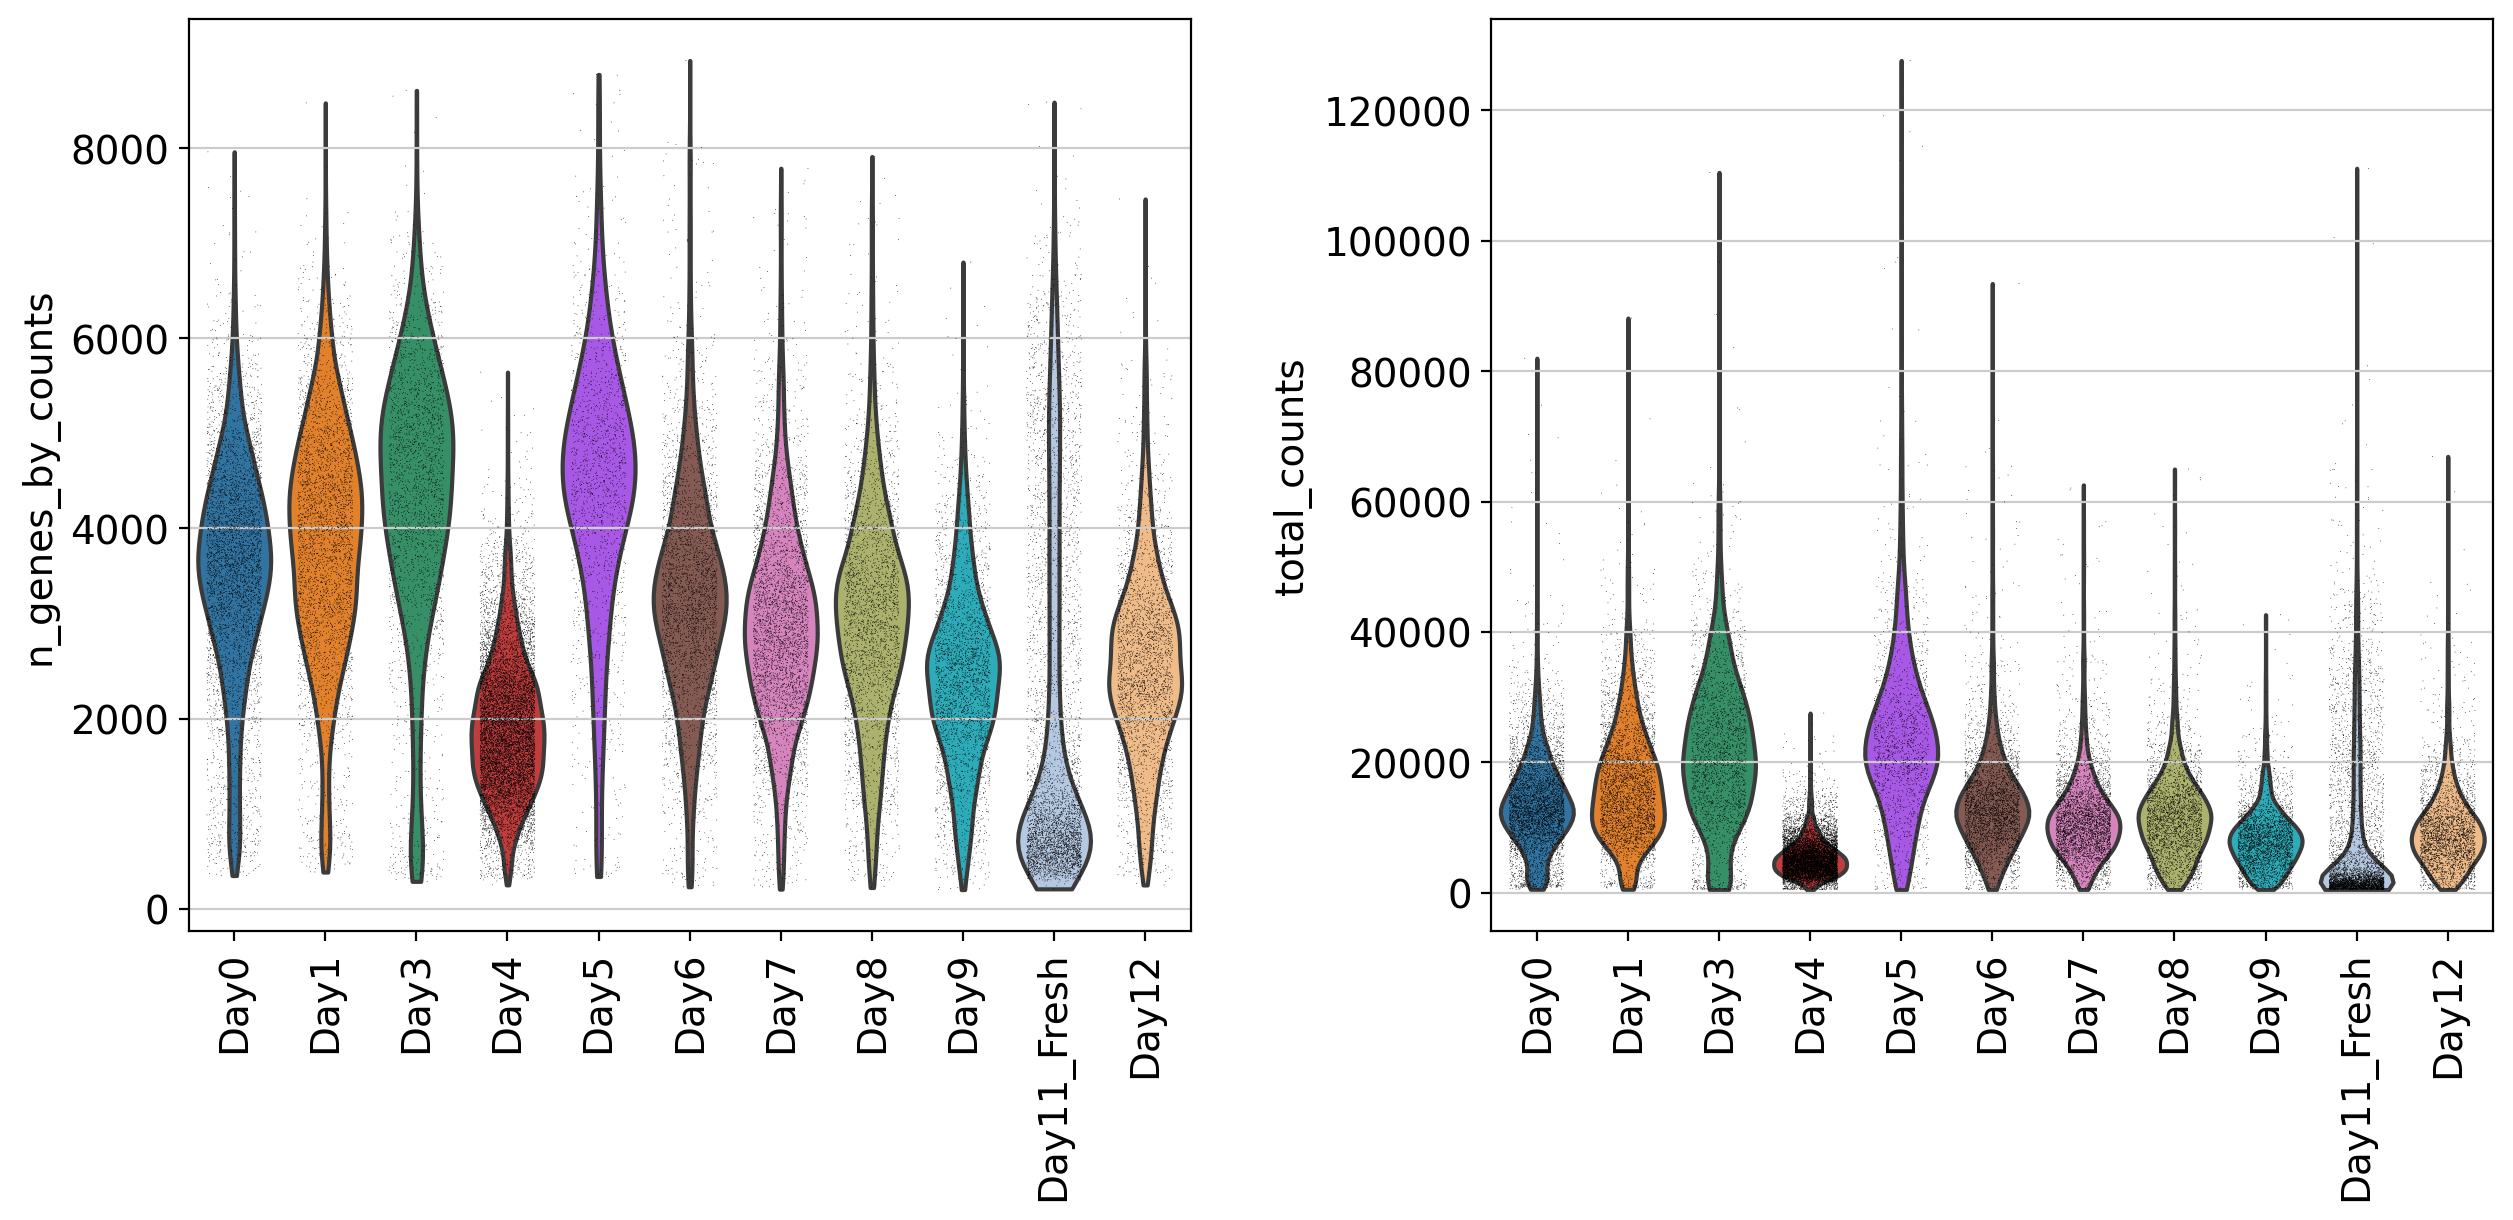

In [7]:
sc.pl.violin(RNA_days, ['n_genes_by_counts', 'total_counts'],
             jitter=0.3, multi_panel=True,size=0.3,rotation=90,
             groupby='label', save = False)

/home/jo/anaconda3/envs/wip/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


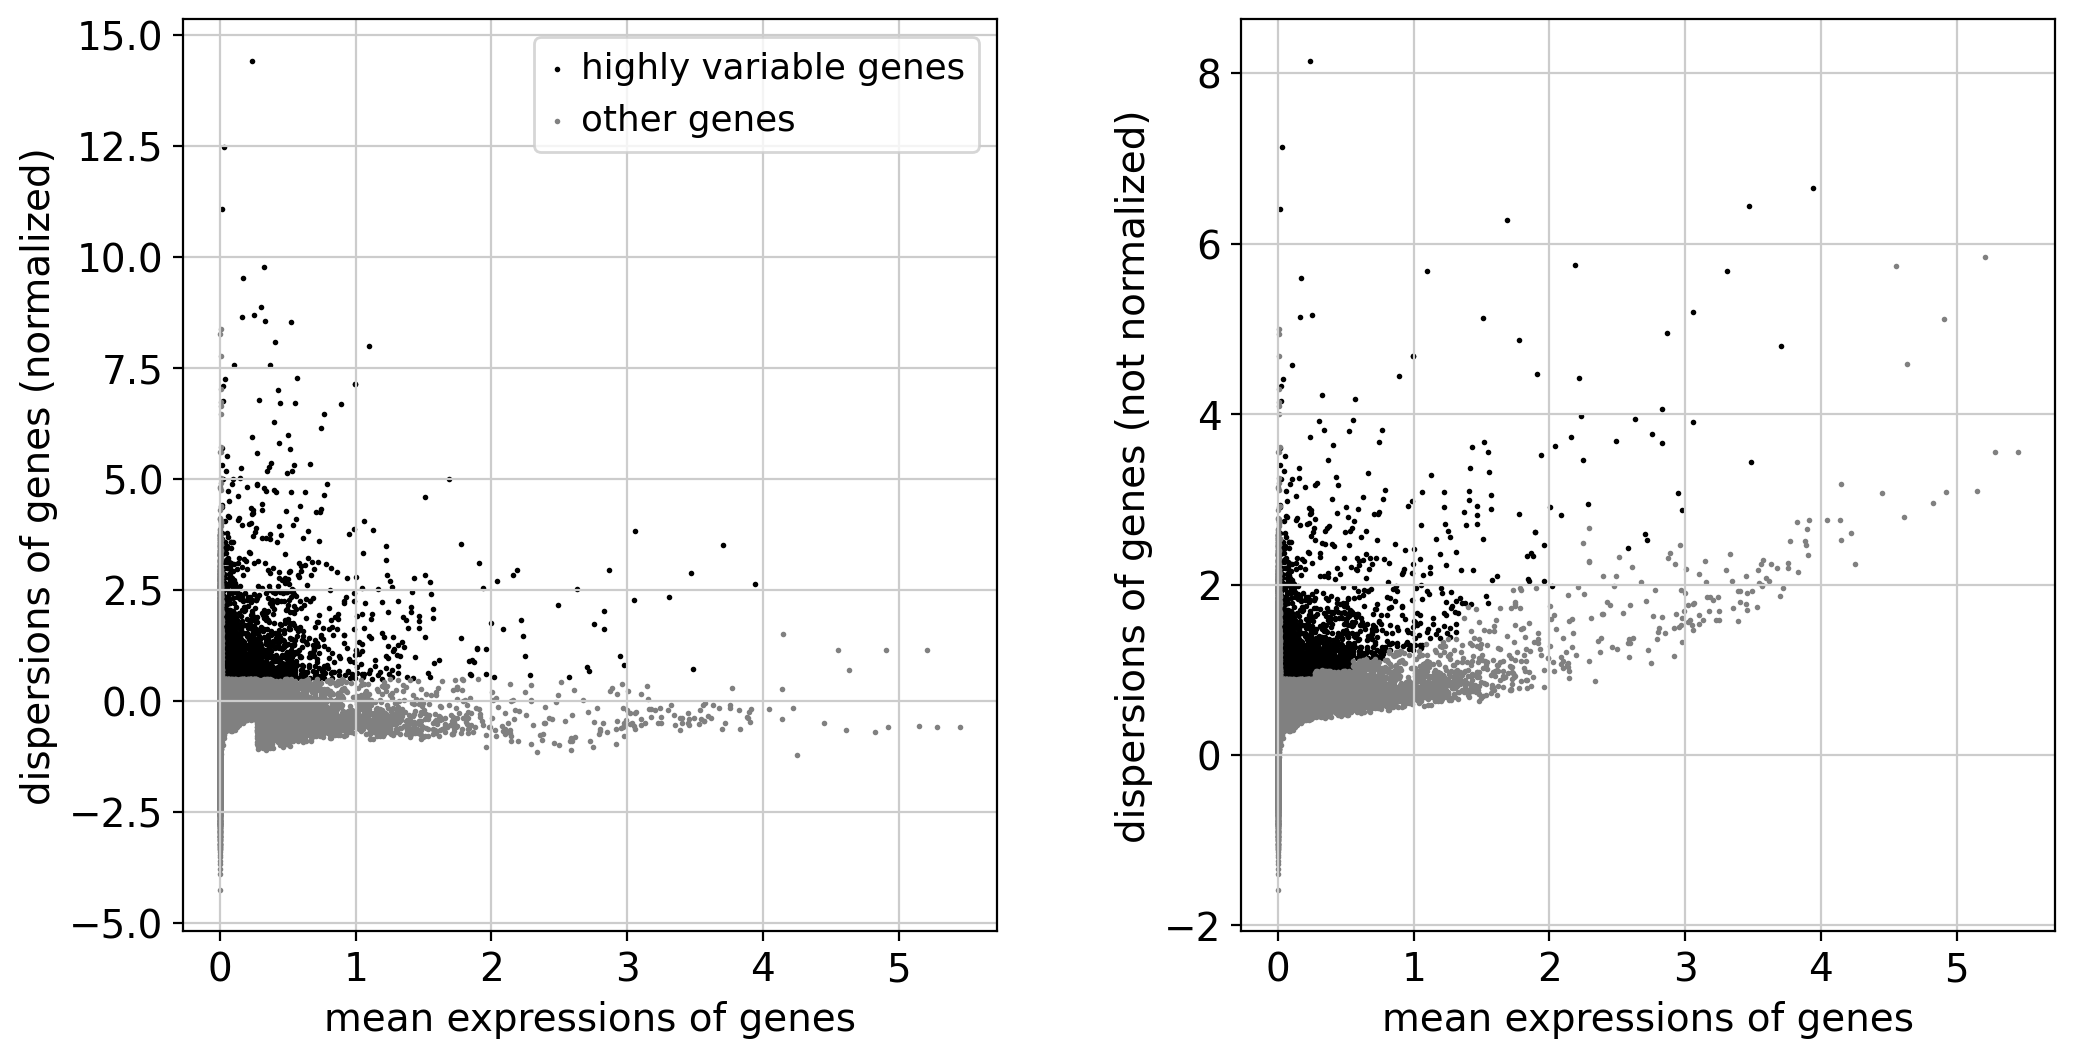

In [9]:
# normalization
sc.pp.normalize_total(RNA_days, target_sum=1e4)
sc.pp.log1p(RNA_days)

# variable genes
sc.pp.highly_variable_genes(RNA_days, min_mean=0.0125, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(RNA_days, save = True)

In [10]:
RNA_days.raw = RNA_days
RNA_days = RNA_days[:, RNA_days.var.highly_variable]
gene_count = np.count_nonzero(RNA_days.var.highly_variable)
print("There are ", RNA_days.n_obs, " cells passed quality control")
print("There are ", gene_count, " highly variable genes")

There are  44370  cells passed quality control
There are  2292  highly variable genes


/home/jo/anaconda3/envs/wip/lib/python3.7/site-packages/ipykernel_launcher.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  


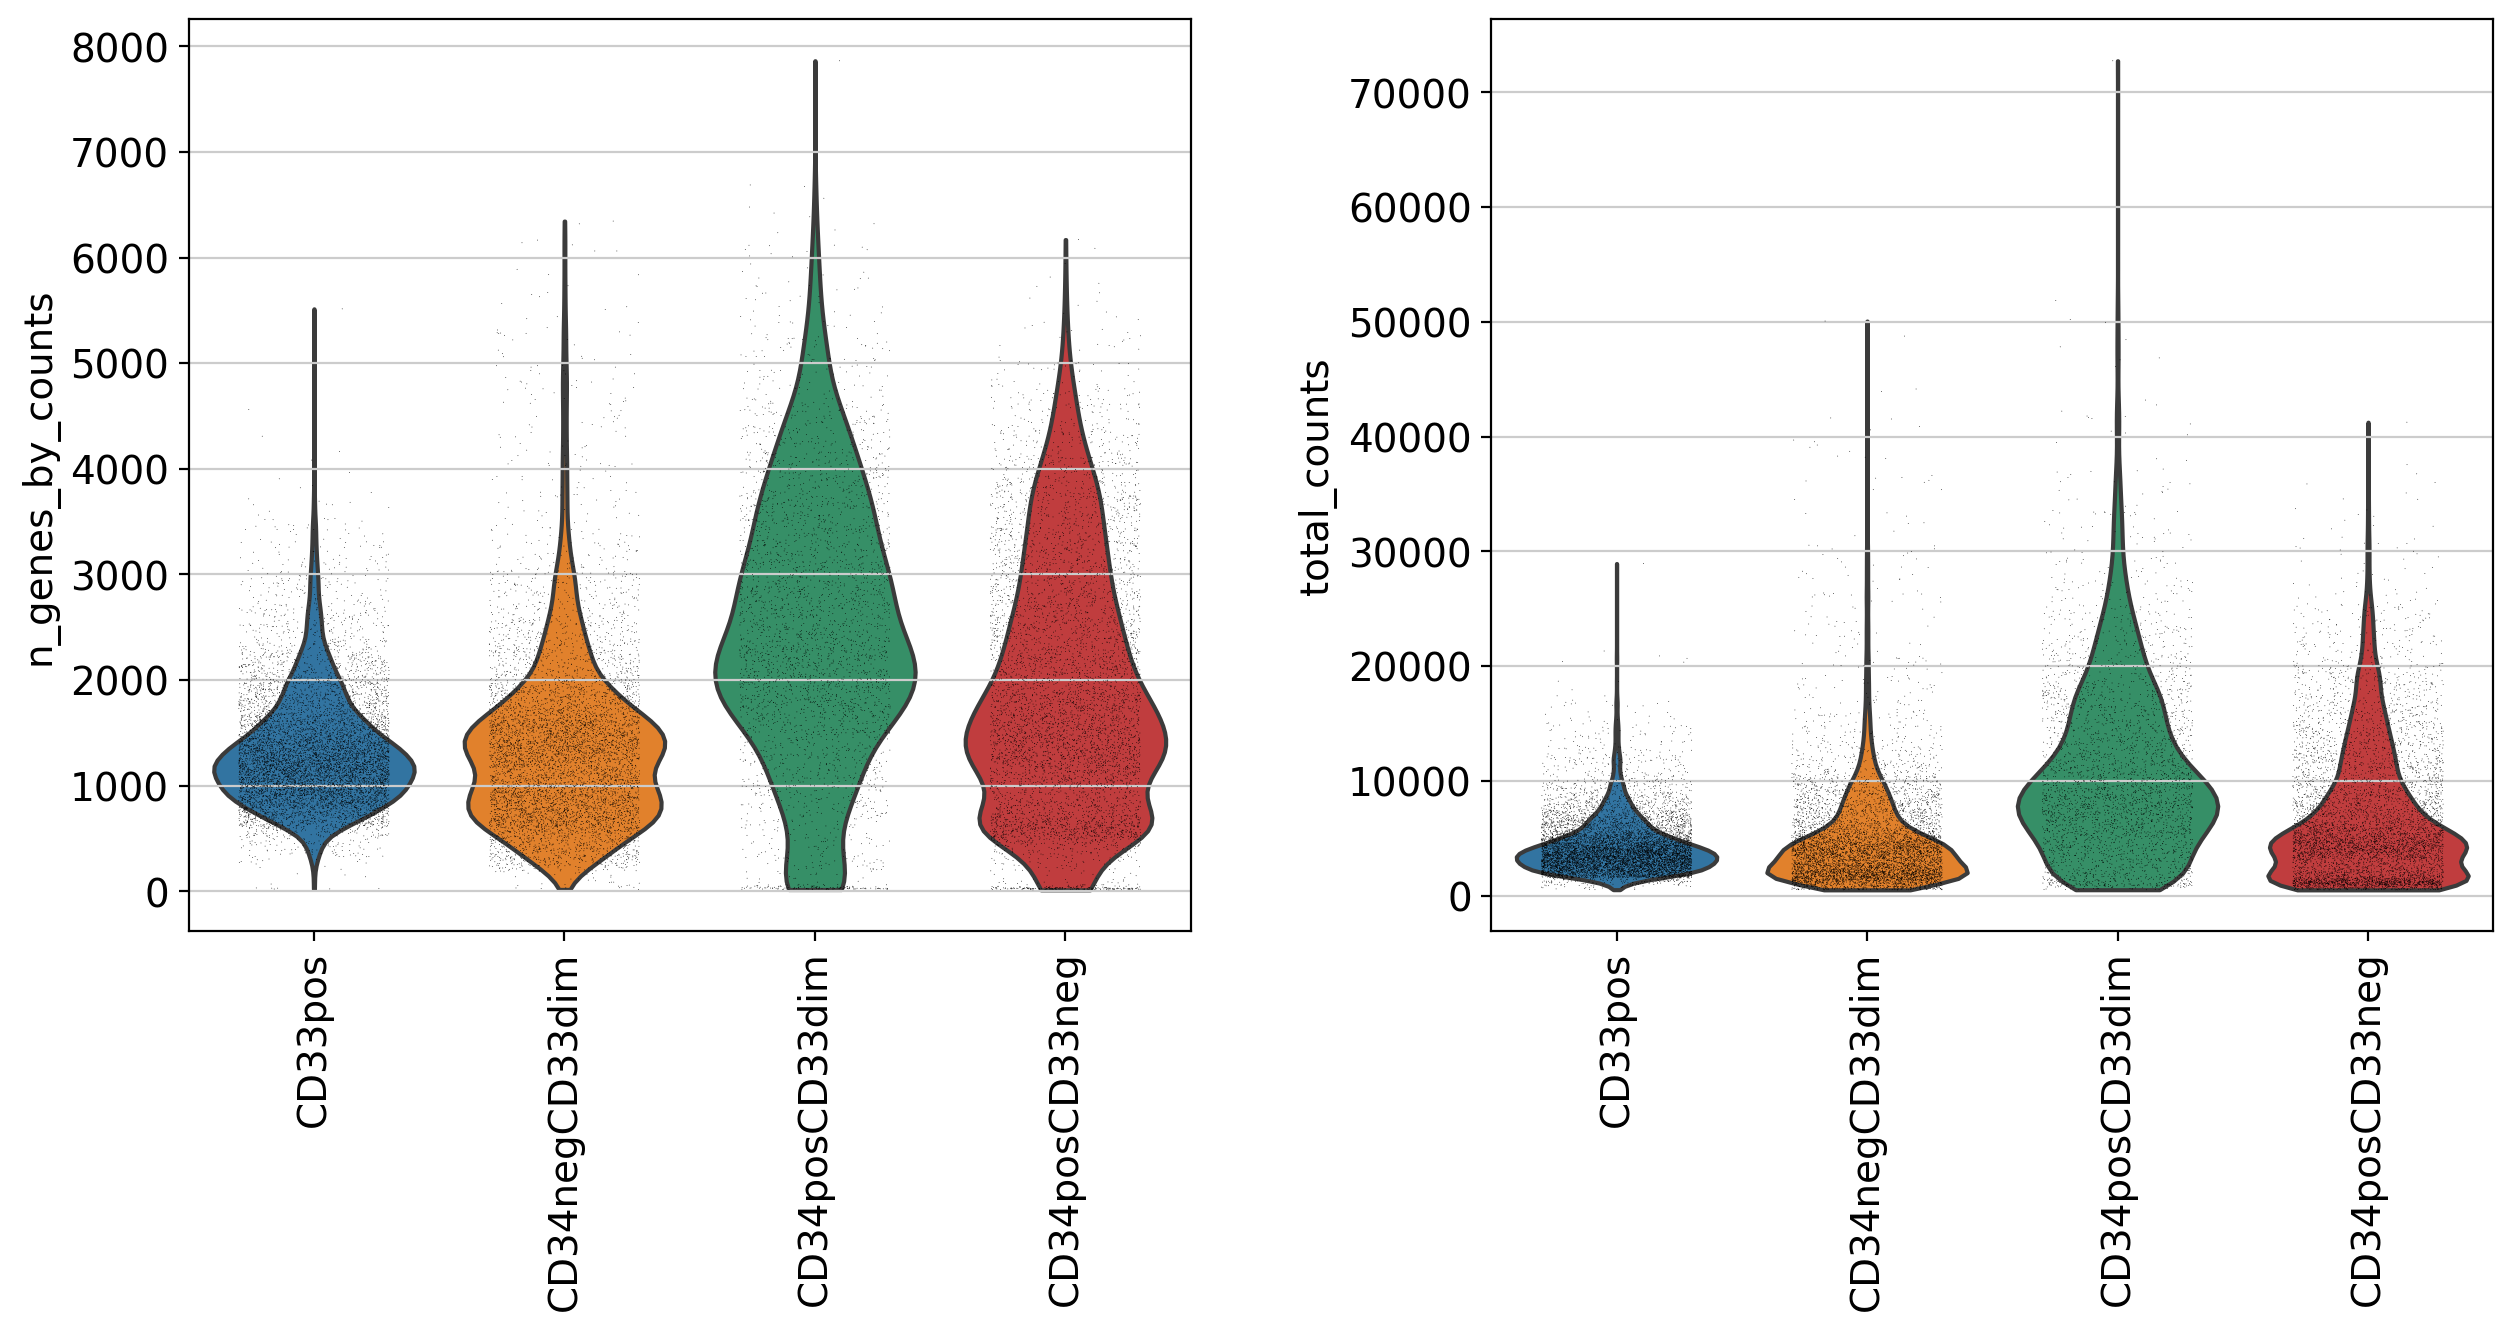

In [11]:
### before filtering
RNA_ref.var['mt'] = RNA_ref.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(RNA_ref, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(RNA_ref, ['n_genes_by_counts', 'total_counts'],
             jitter=0.3, multi_panel=True,size=0.3,rotation=90,
             groupby='label', save = False)

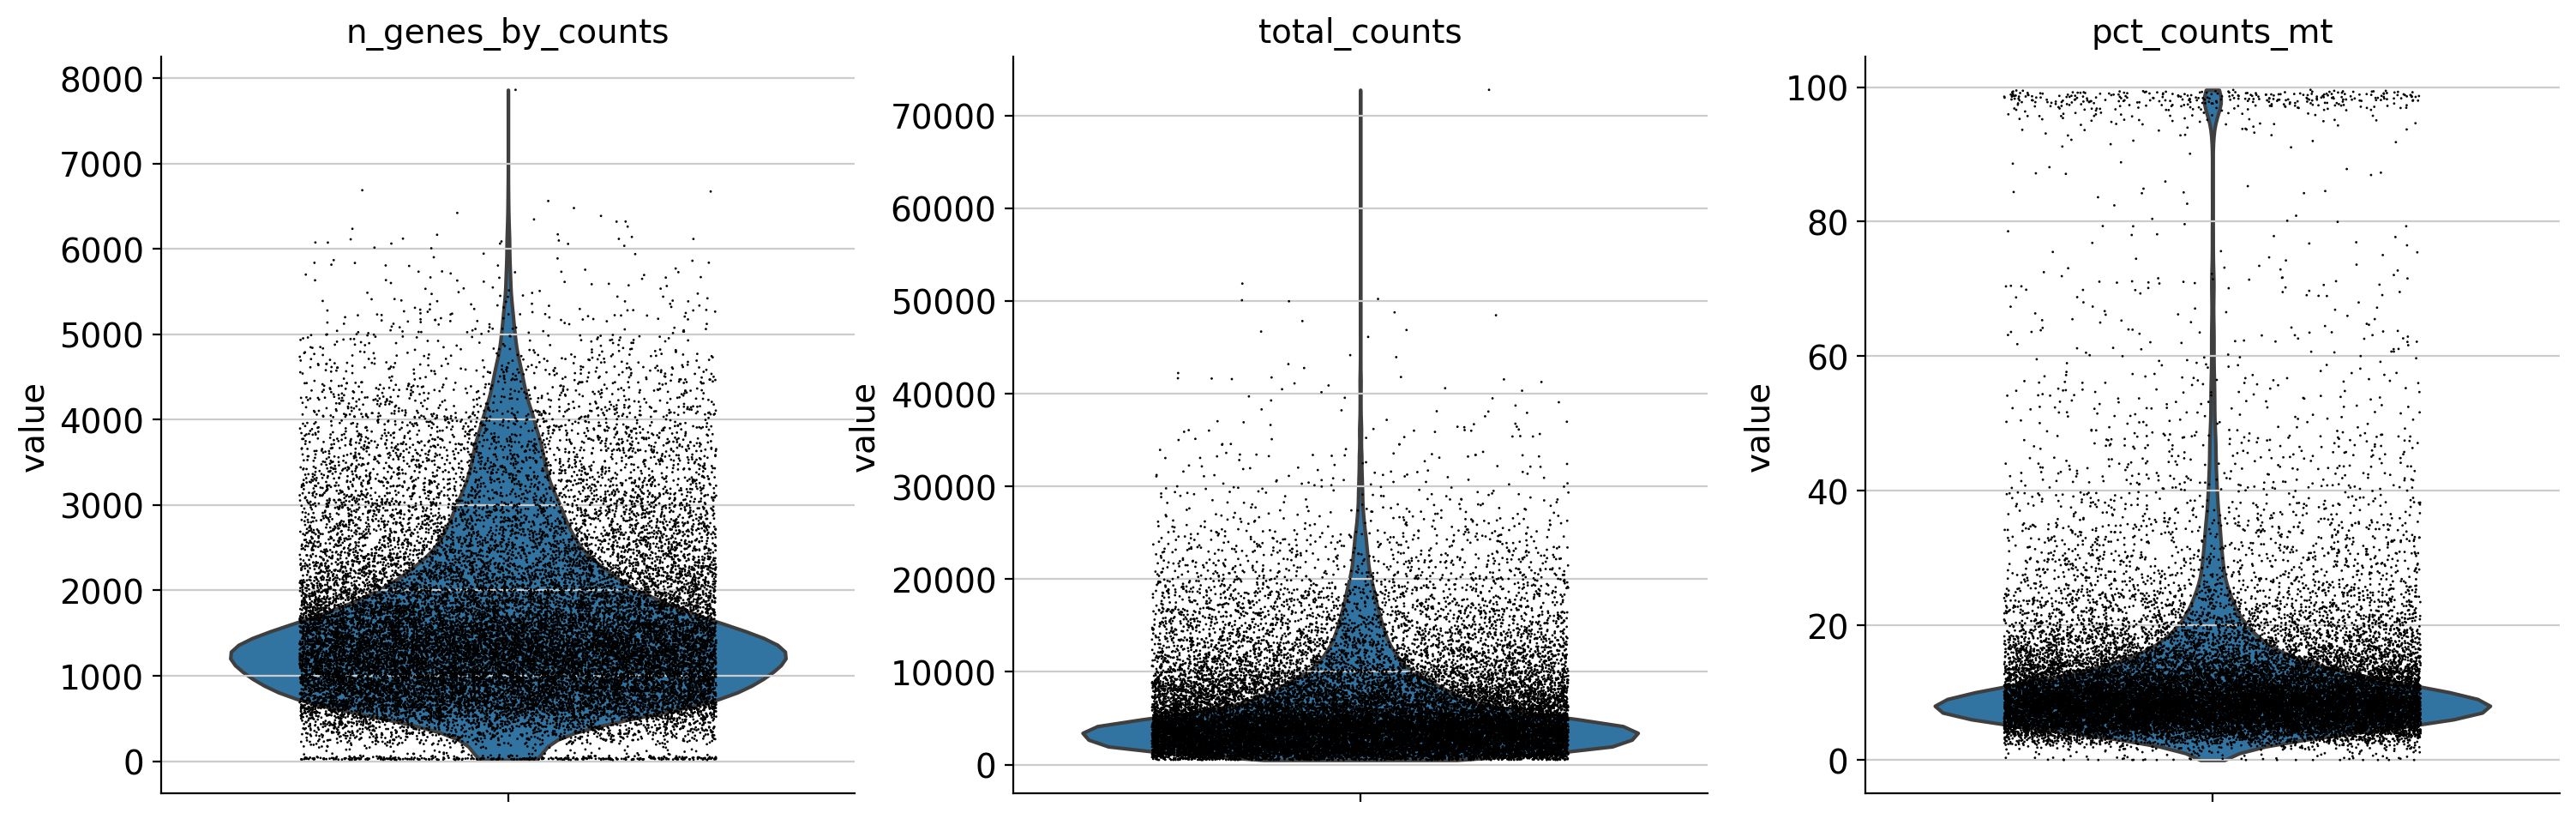

In [12]:
sc.pl.violin(RNA_ref, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.3, multi_panel=True, save = False)

In [13]:
sc.pp.filter_cells(RNA_ref, min_genes=200)
sc.pp.filter_genes(RNA_ref, min_cells=3)

RNA_ref = RNA_ref[RNA_ref.obs.n_genes_by_counts < 7000, :]
RNA_ref = RNA_ref[RNA_ref.obs.pct_counts_mt < 25, :]

RNA_ref

filtered out 441 cells that have less than 200 genes expressed
filtered out 11833 genes that are detected in less than 3 cells


View of AnnData object with n_obs × n_vars = 22804 × 21705
    obs: 'barcode', 'sample_id', 'label', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'label_colors'

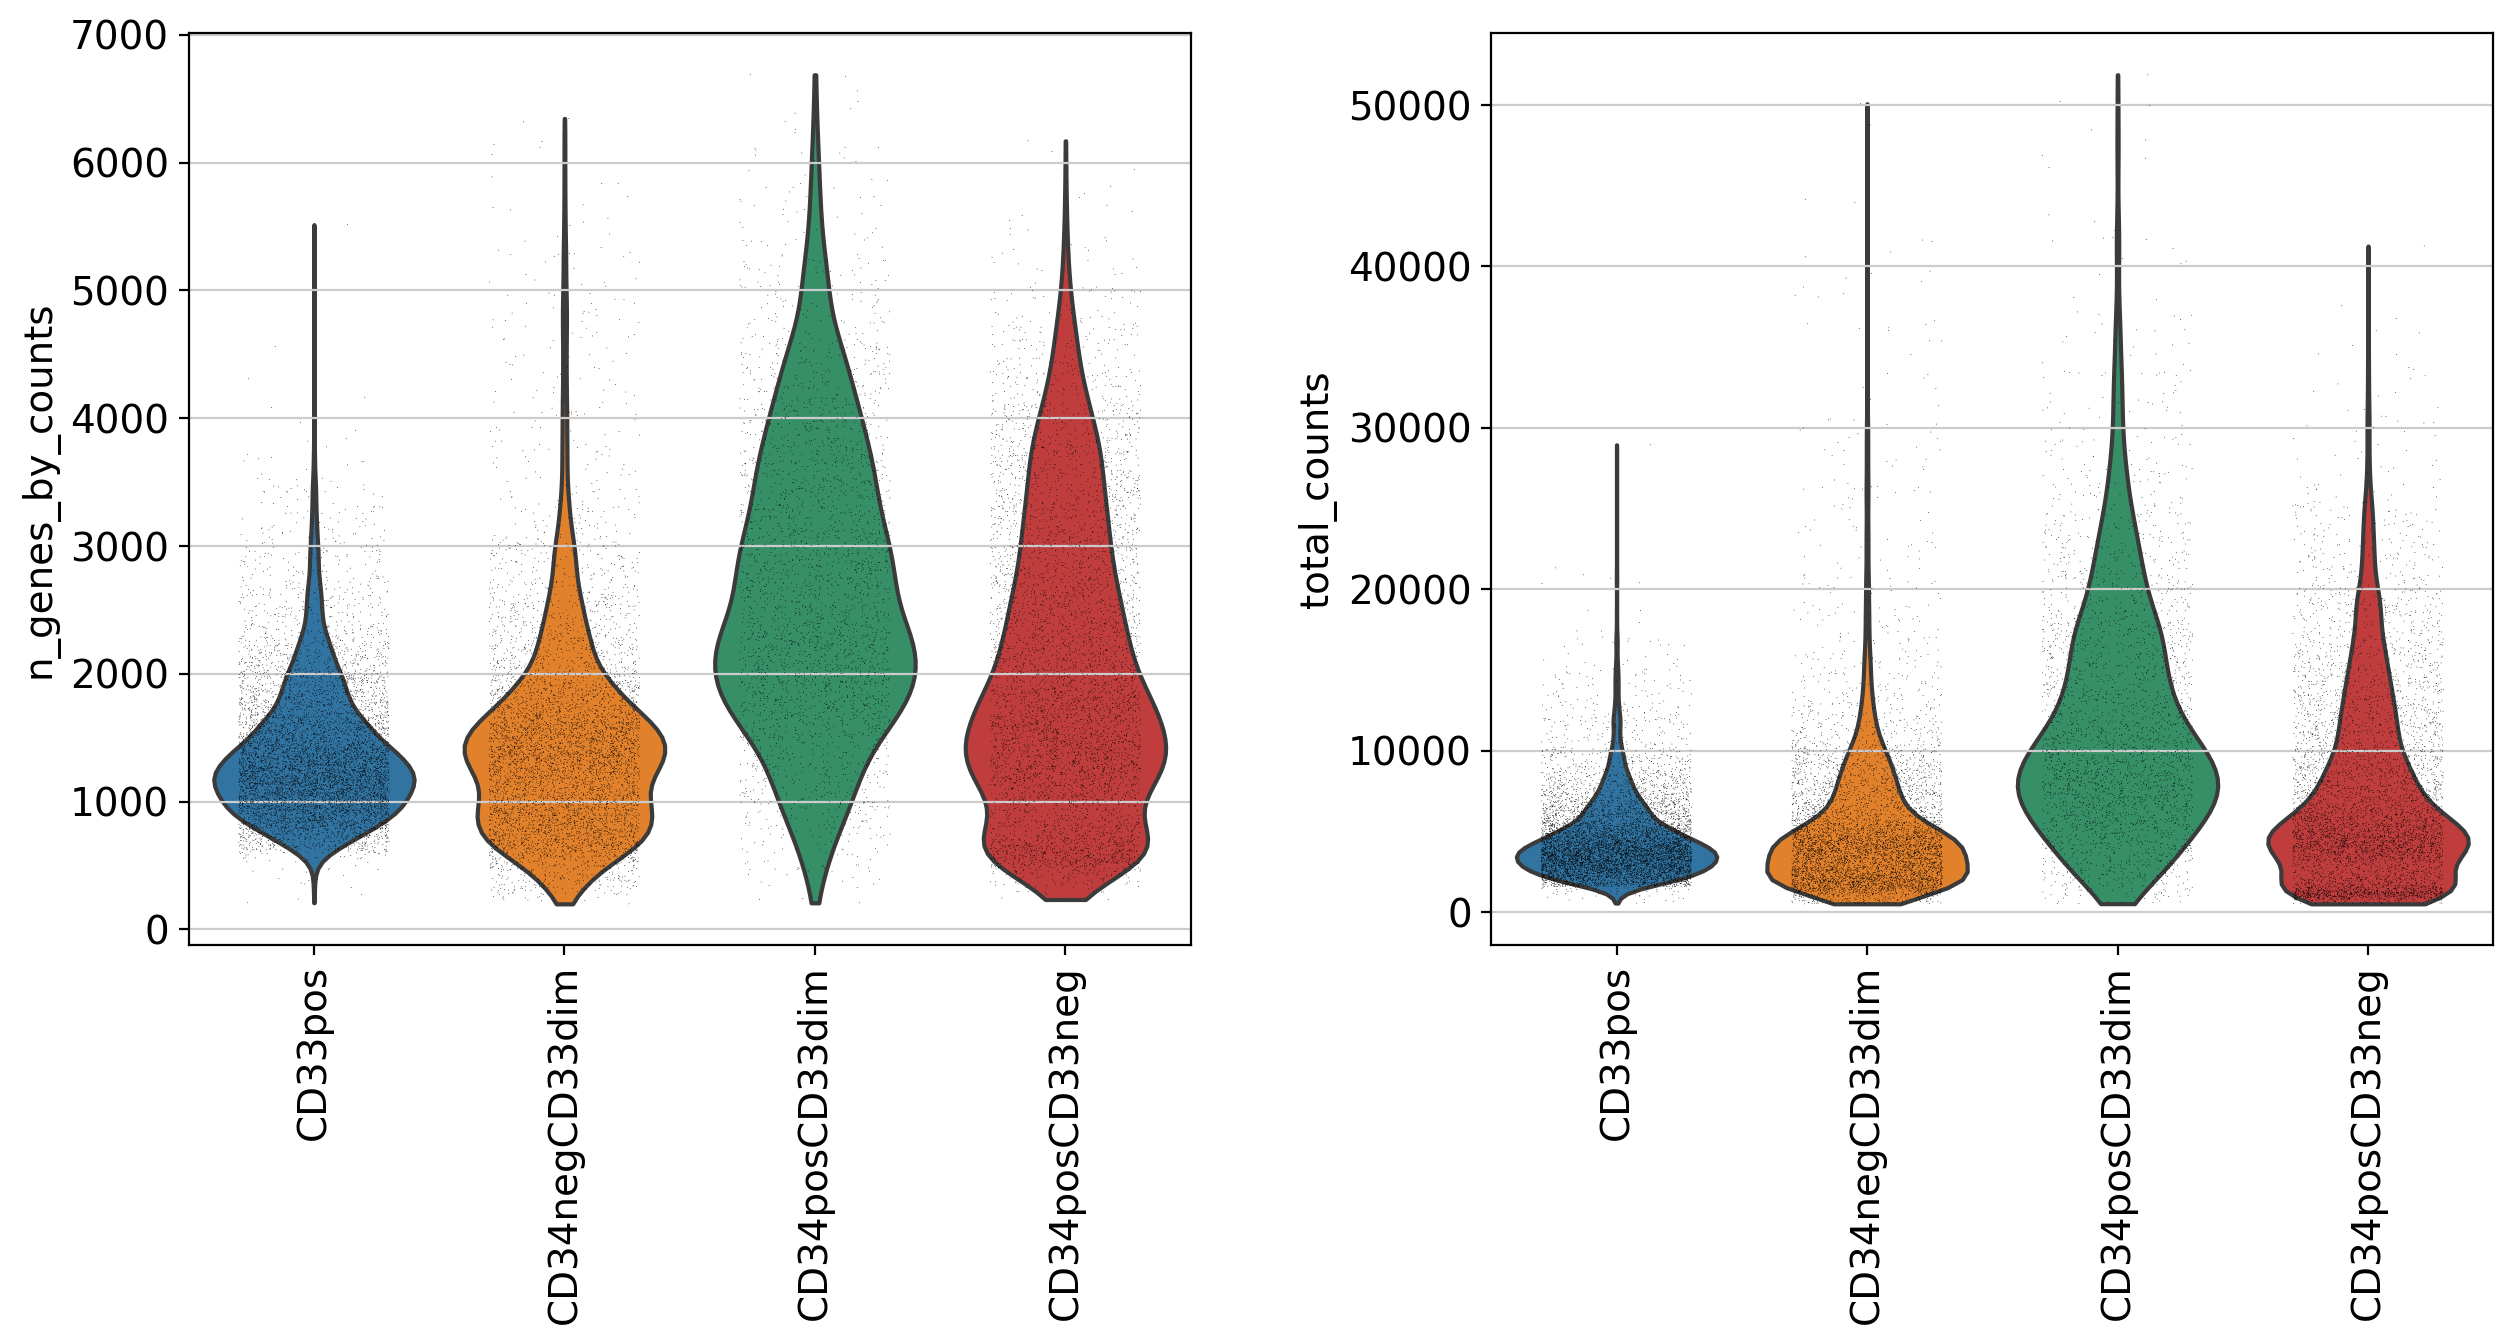

In [14]:
sc.pl.violin(RNA_ref, ['n_genes_by_counts', 'total_counts'],
             jitter=0.3, multi_panel=True,size=0.3,rotation=90,
             groupby='label', save = False)

/home/jo/anaconda3/envs/wip/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


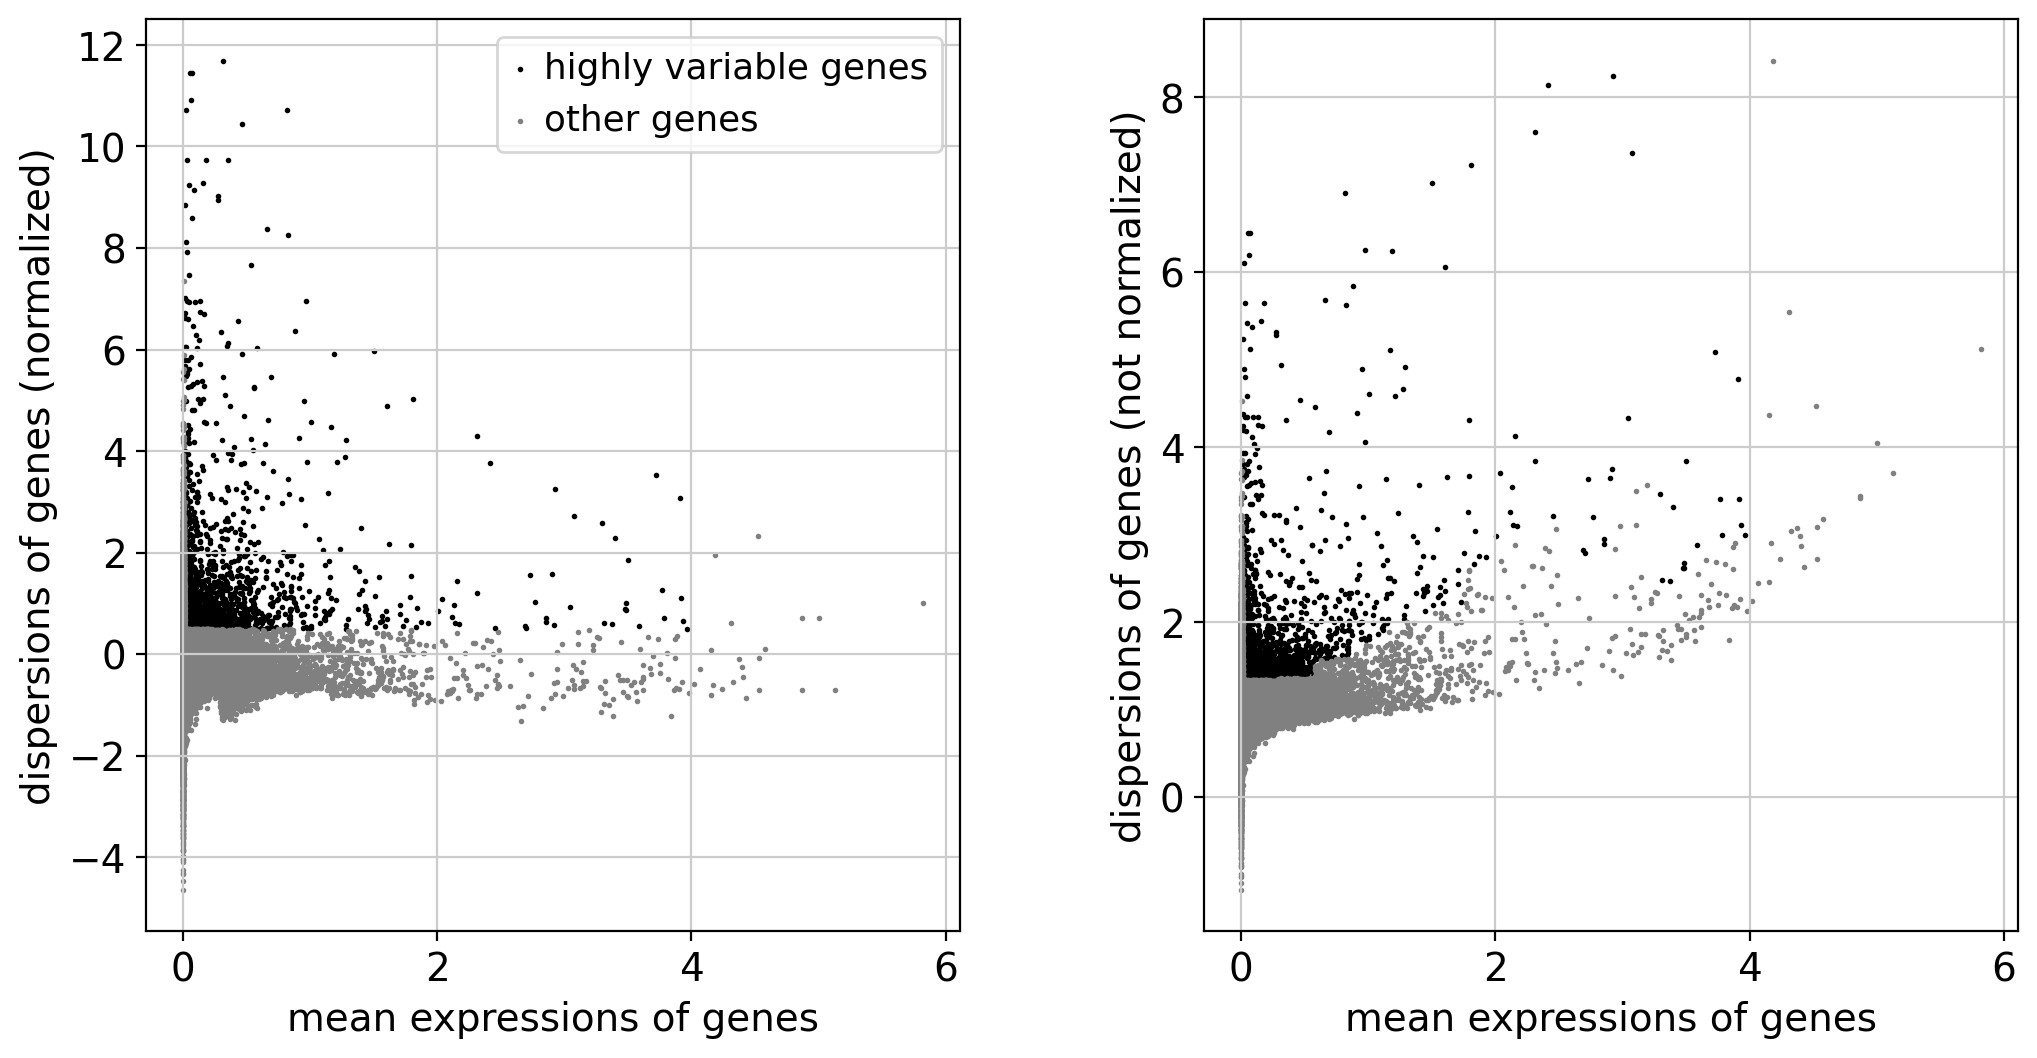

In [15]:
# normalization
sc.pp.normalize_total(RNA_ref, target_sum=1e4)
sc.pp.log1p(RNA_ref)

# variable genes
sc.pp.highly_variable_genes(RNA_ref, min_mean=0.0125, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(RNA_ref, save = True)

In [16]:
RNA_ref.raw = RNA_ref
RNA_ref = RNA_ref[:, RNA_ref.var.highly_variable]
gene_count = np.count_nonzero(RNA_ref.var.highly_variable)
print("There are ", RNA_ref.n_obs, " cells passed quality control")
print("There are ", gene_count, " highly variable genes")

There are  22804  cells passed quality control
There are  1979  highly variable genes


In [17]:
RNA_days.write('result_1a-RNA_preprocessing/RNA_days.h5ad')
RNA_ref.write('result_1a-RNA_preprocessing/RNA_CD.h5ad')